## Prediction duration of a ride based on NYC cabs records
[Dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

Model to be deployed using MLOps techniques.

In [79]:
import pickle 

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [73]:
def prep_data(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    
    x_dicts = df[categorical + numerical].to_dict(orient='records')

    target = 'duration'
    y = df[target].values
    
    return x_dicts, y

In [74]:
train_dicts, y_train = prep_data('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
validation_dicts, y_validation = prep_data('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

dv = DictVectorizer() # need to be the same (tokenize)

X_train = dv.fit_transform(train_dicts)  
X_validation = dv.transform(validation_dicts)  

In [75]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_validation)
root_mean_squared_error(y_validation, y_pred) # minutes error

7.758715206809494

/tmp/ipykernel_18347/2292603881.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_18347/2292603881.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_validation, label='actual')


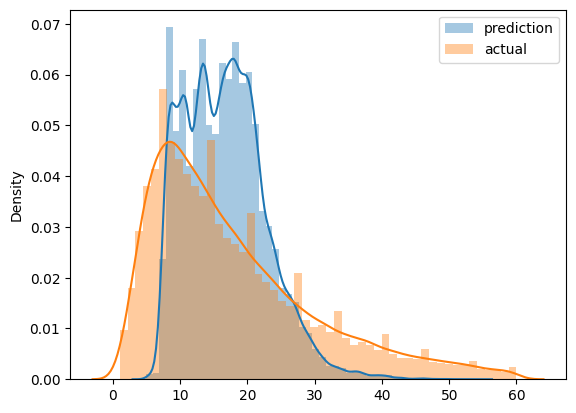

In [62]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_validation, label='actual')

plt.legend()

In [76]:
l = Lasso(alpha=0.001)
l.fit(X_train, y_train)

y_pred = l.predict(X_validation)
root_mean_squared_error(y_validation, y_pred) # minutes error

9.23343622815571

In [80]:
with open('models/lin_reg.bin', 'wb') as f_out: # saving model as it was the best 
    pickle.dump((dv, lr), f_out)

In [ ]:
# might be interesting to track the results for each model, by taking notes or using Experiment Tracker
# Model Registry shows more info on models (which one, its metrics)
# Keeping track of historical metrics - MLFlow

In [7]:
from mermaid import Mermaid

mermaid_code = """
flowchart TD
    A[Load and Prepare Data] --> B[Vectorize]
    B --> C[Train]
"""

chart = Mermaid(mermaid_code)

In [8]:
chart # steps in this notebook that will be transformed in a mlops pipeline